# ResNet - Imagenette - Keras


The goal of this implementation is to study the impact of model's architecture and how does the hyperparameter works together to improve a model performance.

> Therefore, the optimisation is defined and fixed. We'll use Adam optimiser with a `learning_rate` of .0003

The dataset comes from https://github.com/fastai/imagenette
The full-dataset was downloaded, it's a part of tensorflow-dataset library.

## Imports

In [1]:
import time
import warnings
import pathlib
warnings.filterwarnings('ignore')

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
!pip freeze | grep -e "tensorflow==" -e "keras=="

keras==2.10.0


In [4]:
import tensorflow as tf

from tensorflow.keras import layers, Model, Input, callbacks
from tensorflow.keras.regularizers import L2

2023-02-01 10:54:20.012824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 10:54:20.154851: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-01 10:54:20.800416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-01 10:54:20.800453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [5]:
from tqdm.keras import TqdmCallback
import tensorflow_datasets as tfds

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU: {device_name}')

Found GPU: /device:GPU:0


2023-02-01 10:54:22.297677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 10:54:22.332673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:54:22.388275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:54:22.388464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import numpy as np

In [21]:
# Fixing seed for Python, NumPy, and TensorFlow
seed = 0
tf.keras.utils.set_random_seed(seed)

## Load and prepare data

In [10]:
data_dir_train = '../datasets/imagenette2/train/'
data_dir = pathlib.Path(data_dir_train)

data_dir_val = '../datasets/imagenette2/val/'
data_dir = pathlib.Path(data_dir_val)

In [11]:
batch_size=32
img_height=224
img_width=224
channel=3

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9469 files belonging to 10 classes.
Using 7576 files for training.


2023-02-01 10:54:25.654450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:54:25.654704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:54:25.654875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:54:25.655267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 10:54:25.655448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_val,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3925 files belonging to 10 classes.
Using 3140 files for training.


In [14]:
class_names = train_ds.class_names
no_classes = len(class_names)
print(f'Nb classes: {no_classes} -> {class_names}')

Nb classes: 10 -> ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


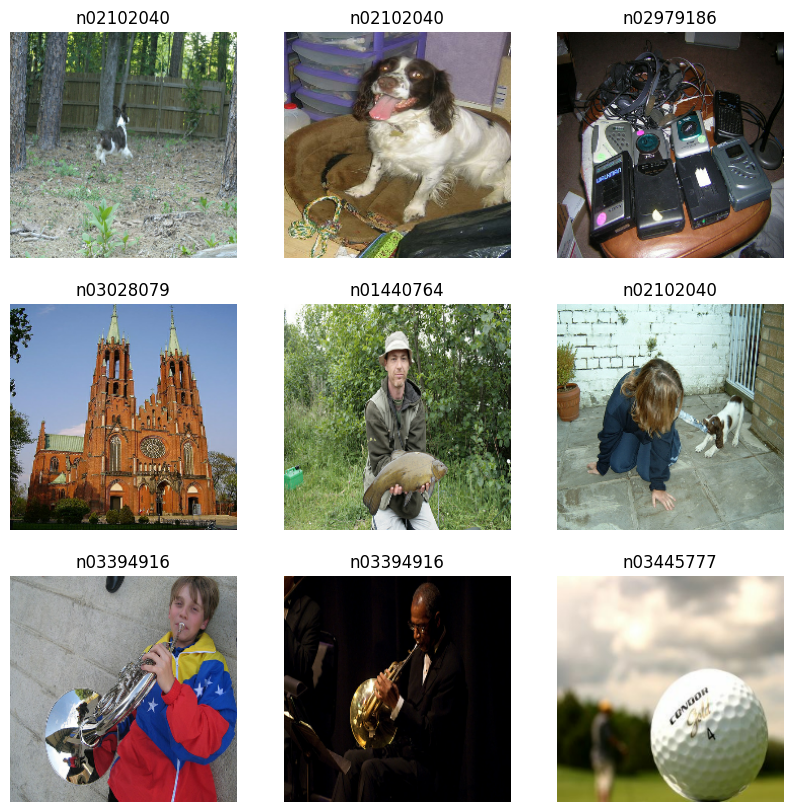

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.00016686496 1.0


## Let's build and compare models

### ResNet34 - Without residual connection

In [35]:
model_name = 'resnet-34-noresidual'
batch_size = 256
epochs = 100

In [43]:
def conv2d_block(X, filters, kernel_size, stride, with_shortcut, pool=False):
    X_shortcut = X
    
    X = layers.Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), padding='same')(X)
    X = layers.BatchNormalization()(X)
    if pool:
        X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)    
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), padding='same')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    
    if with_shortcut:
        X = layers.Add()([X, X_shortcut])
        
    return X

In [44]:
def get_resnet(input_shape=(224, 224, 3)):
    X_input = layers.Input(input_shape)
    
    X = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(1, 1), padding='same')(X_input)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    
    X = conv2d_block(X, 64, 3, 1, False, True)
    X = conv2d_block(X, 64, 3, 1, False)
    X = conv2d_block(X, 64, 3, 1, False)

    X = conv2d_block(X, 128, 3, 1, False, True)
    X = conv2d_block(X, 128, 3, 1, False)
    X = conv2d_block(X, 128, 3, 1, False)
    X = conv2d_block(X, 128, 3, 1, False)
    
    X = conv2d_block(X, 256, 3, 1, False, True)
    X = conv2d_block(X, 256, 3, 1, False)
    X = conv2d_block(X, 256, 3, 1, False)
    X = conv2d_block(X, 256, 3, 1, False)
    X = conv2d_block(X, 256, 3, 1, False)
    X = conv2d_block(X, 256, 3, 1, False)
    
    X = conv2d_block(X, 512, 3, 1, False, True)
    X = conv2d_block(X, 512, 3, 1, False)
    X = conv2d_block(X, 512, 3, 1, False)
    
    ### Prediction bloc
    X = layers.Flatten()(X) 
    X = layers.Dense(1000)(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Dense(no_classes)(X)
    X_output = layers.Activation('softmax')(X)
    return Model(inputs=[X_input], outputs=[X_output], name=model_name)

In [45]:
img_shape = (img_height, img_width, channel)
img_shape

(224, 224, 3)

In [46]:
# Define model, for a fully-connected network the input must be properly adapted
model = get_resnet(img_shape)
model.summary()

Model: "resnet-34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_117 (Conv2D)         (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_115 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_119 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 conv2d_118 (Conv2D)         (None, 112, 112, 64)      36

In [ ]:
# Set hyperparameters
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(3e-4)
metric = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_acc')
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25),
    TqdmCallback(verbose=0)
]

# Initialize trainer
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Train model
start_time = time.time()
results = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=0 # Supress fitting information
)

In [122]:
predictions = model.predict(val_ds)
score = tf.nn.softmax(predictions)
print(f'Execution time: {round(time.time() - start_time, 2)}s, Accuracy: {np.max(score)*100}')

99/99 [==============================] - 3s 32ms/step
Execution time: 10559.79s, Accuracy: 23.196931183338165


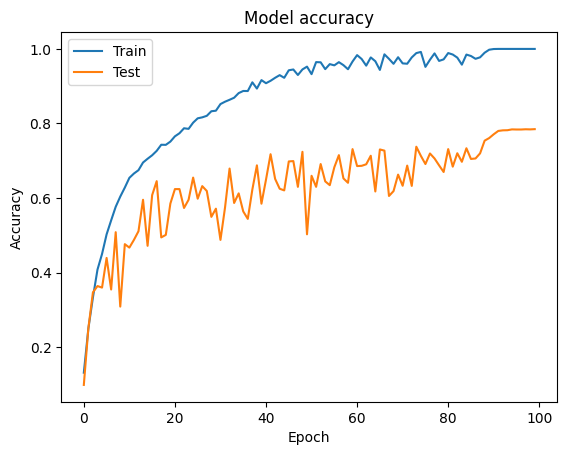

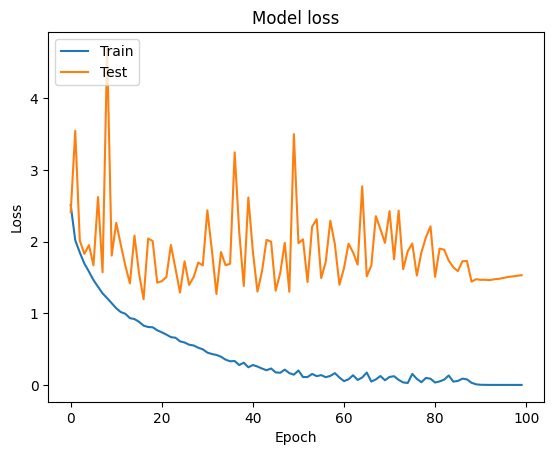

In [110]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [125]:
predicted_categories = tf.argmax(predictions, axis=1)
true_categories = tf.concat([y for x, y in val_ds], axis=0)
confusion = confusion_matrix(predicted_categories, true_categories)

Accuracy on validation set: 23.196931183338165%


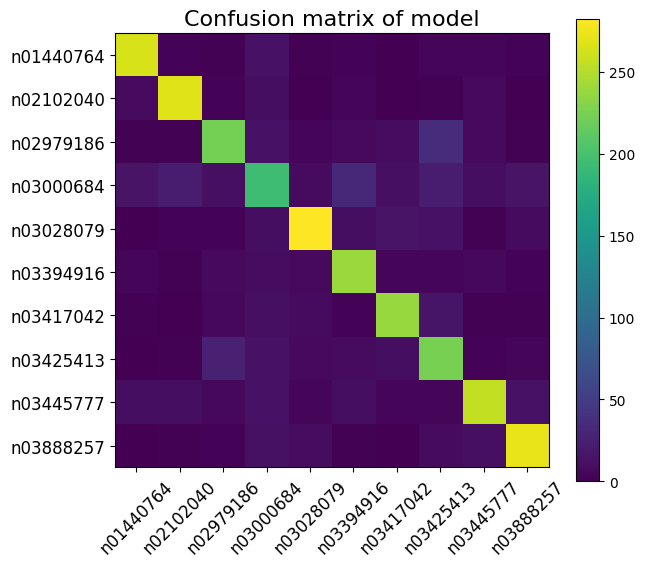

In [128]:
print(f'Accuracy on validation set: {np.max(score)*100}%')

plt.figure(figsize=(7, 6))
plt.title(f'Confusion matrix of model', fontsize=16)
plt.imshow(confusion)
plt.xticks(np.arange(10), class_names, rotation=45, fontsize=12)
plt.yticks(np.arange(10), class_names, fontsize=12)
plt.colorbar()
plt.show()

In [55]:
model_file = f'{model_name}.h5'
print(f'Saving model to the current directory under {model_file} file')
model.save(f'{model_file}')

Saving model to the current directory under resnet-34.h5 file
